# Checking Selection

In this notebook, we check the selection of the input sample. 

In [1]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")
from main import copacabana
from make_input_files.make_input_datasets import *


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using Modified sklearn.mixture.GMM, modified to allow data weights


In [2]:

import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [245]:
cfg = '../config_files/config_buzzard_v2.yaml'
copa = copacabana(cfg)

# copa.kwargs['dmag_lim'] = 1
d1, d2 = [], []
for mfile in copa.master_fname_tile_list:
    g, c = load_copa_input_catalog(mfile,copa.kwargs,pz_file='dnf_model',simulation=True)
    d1.append(g)
    d2.append(c)

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles/buzzard_v2.0.0_copa_golden_00032.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/y3/output/tiles
loading clusters
loading full members catalog
making color columns
selecting fake photo-z catalog
making galaxies cut
galaxy catalog
all:  44915
cut:  5333
assigning background galaxies
computing physical quantities
loading clusters
loading full members catalog
making color columns
selecting fake photo-z catalog
making galaxies cut
galaxy catalog
all:  2406928
cut:  256686
assigning background galaxies
computing physical quantities


In [246]:
gal = vstack(d1)

In [247]:
cat = vstack(d2)

In [248]:
mask = g['Bkg']
np.count_nonzero(mask)

137824

### Check Background

In [249]:
r_in  = copa.kwargs['r_in']
r_out = copa.kwargs['r_out']

radii = g['R']*0.7

Text(0.5,0,'R [Mpc]')

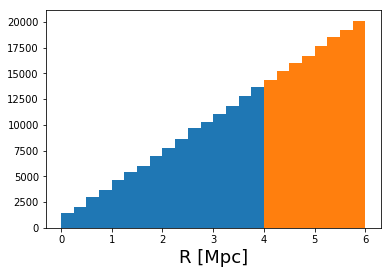

In [202]:
dr = 0.25
rbins = np.arange(0,r_out+dr,dr)

plt.hist(radii,bins=rbins)
plt.hist(radii[mask],bins=rbins)
plt.xlabel('R [Mpc]',fontsize=18)

### Select only true members

In [203]:
def chunks(ids1, ids2):
    """Yield successive n-sized chunks from data"""
    for id in ids2:
        w, = np.where( ids1==id )
        yield w

In [204]:
gt = g[g['True']]

In [205]:
gcidx = gt['CID']
cidx  = c['CID']

r200  = c['R200_true']
m200  = c['M200_true']
zcls  = c['redshift']

In [206]:
keys  = list(chunks(gcidx,cidx))

In [207]:
len(gt)

4783

### Sky Plot

In [208]:
def sky_plot(RA,DEC,title="Buzzard v1.6 - 1000 GC",savefig='./img/sky_plot.png'):
    import matplotlib.pyplot as pplot
    import astropy.coordinates as coord
    from astropy import units as u
    
    ra = coord.Angle(RA*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(DEC*u.degree)

    fig = pplot.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="aitoff")
    plt.title(title)
    ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    ax.grid(True)
    ax.scatter(ra.radian, dec.radian, s=10, alpha=0.5)
    plt.subplots_adjust(top=0.9,bottom=0.0)
    # ax.set_xticklabels(['10h','8h','6h','4h','2h','0h','20h','18h','16h','14h','12h'])
    
    #fig.savefig(savefig, bbox_inches = "tight")
    #plt.clf()
    #plt.close()


In [209]:
ra = c['RA']
dec= c['DEC']

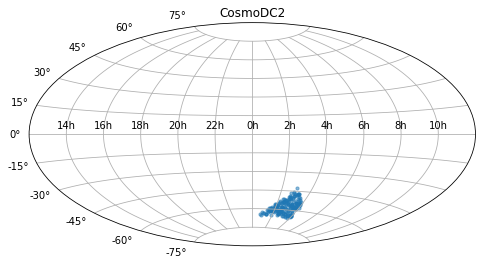

In [210]:
sky_plot(ra,dec,title='CosmoDC2')

(-65.0, -55)

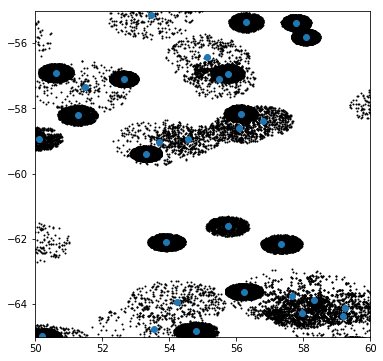

In [211]:
rag= g['RA']
deg= g['DEC']

plt.figure(figsize=(6,6))
plt.scatter(rag,deg,color='k',s=1)
plt.scatter(ra,dec)
plt.xlim(50,60)
plt.ylim(-65.,-55)

### HOD Model

In [212]:
def compute_n200(data,r200):
    mask = data['R']<=r200
    return np.count_nonzero(mask)

In [213]:
n200 = np.array([compute_n200(gt[idx],r200[i]) for i, idx in enumerate(keys)])

Text(0.5,0,'$M_{200,m}$')

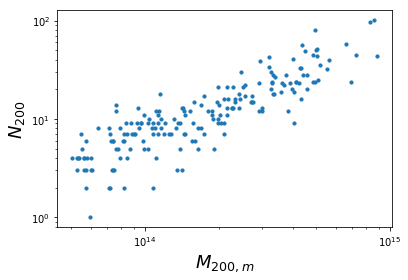

In [214]:
plt.scatter(m200,n200,s=10)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$N_{200}$',fontsize=18)
plt.xlabel(r'$M_{200,m}$',fontsize=18)
# plt.title(run,fontsize=18)

In [215]:
np.log10(1/0.7)

0.15490195998574316

### Magnitude Model

In [216]:
idx = g['True']

In [217]:
amag= g['Mr'][idx]#-5*np.log10(0.7)
mag = g['mag'][idx]
zcls= g['redshift'][idx]
dmag= g['dmag'][idx]

Text(0.5,1,'Only True Members')

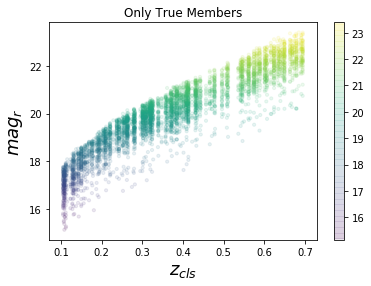

In [218]:
plt.scatter(zcls,mag[:,1],c=amag,s=10,alpha=0.1)
plt.colorbar()
plt.xlabel(r'$z_{cls}$',fontsize=18)
plt.ylabel(r'$mag_{r}$',fontsize=18)
plt.title('Only True Members')

Text(0.5,1,'Only True Members')

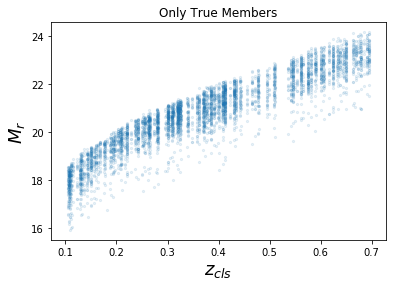

In [219]:
plt.scatter(zcls,amag-5*np.log10(0.7),s=5,alpha=0.1)
plt.ylabel(r'$M_{r}$',fontsize=18)
plt.xlabel(r'$z_{cls}$',fontsize=18)
plt.title('Only True Members')

In [220]:
np.count_nonzero(idx)

4783

### Photoz Properties

In [250]:
idx = np.where(g['mag'][:,2]<=23)[0]

In [251]:
mask = g['True']

In [252]:
zt   = g['z_true'][idx]
zp   = g['z'][idx]
zerr = g['zerr'][idx]

pz0  = g['pz0'][idx]
zcls = g['redshift'][idx]
zoff = g['zoffset'][idx]#-0.09*(1+zcls)
magi = g['mag'][:,2]

In [253]:
dz = (zp-zt)/(1+zt)
dz_abs = np.abs(dz)

In [254]:
bias = np.median(zoff)
print('bias: %.3f'%(bias))

bias: -0.052


In [255]:
zvec = np.linspace(0.01,3,40)
xmin,xmax=-0.1,1.1
def identity(ztru,z,xmin=-0.05,xmax=2.,ax=None,alpha=0.01):
    if ax is None: ax=plt.axes()
    ax.plot(zvec,zvec,ls='--',color='k')
    ax.scatter(ztru,z,alpha=alpha,s=10,label='true members')
    ax.axhline(1.,color='k')
    ax.axvline(1.,color='k')
    ax.set_xlabel(r'$z_{true}$',fontsize=18)
    ax.set_ylabel(r'$z_{ph}$',fontsize=18)
    ax.set_ylim(xmin,xmax)
    ax.set_xlim(xmin,xmax)

Text(0.5,1,'Only True Members')

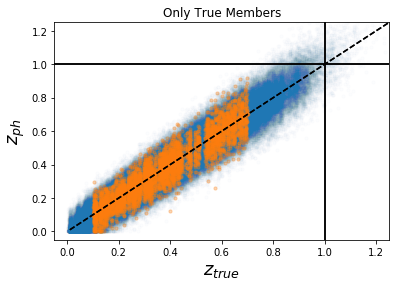

In [256]:
identity(zt,zp,xmax=1.25)
identity(zt[mask],zp[mask],xmax=1.25,alpha=0.3)
plt.title('Only True Members')

In [257]:
def group_by(x,keys):
    return [x[idx] for idx in keys]
    
def get_bins(variable,xedges):
    nbins   = len(xedges)-1
    indices = []
    means = (xedges[1:]+xedges[:-1])/2.
    for i in range(nbins):
        idx = np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0]
        indices.append(idx)
    return indices, means

In [258]:
def fractional_error_percentile(var):
    p16 = np.nanpercentile(var, 16)
    p84 = np.nanpercentile(var, 84)
    score = 0.5*(p84-p16)
    return score

def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data)))

def get_sigmaNMAD(var):
    sigmaNMAD = 1.48*mad(var)
    return sigmaNMAD

def get_outlier_frac(var):
    sigmaNMAD = 1.48*mad(var)
    bias      = np.nanmedian(var)
    out       = np.where(np.abs((var-bias)>=3.*sigmaNMAD))[0]
    frac      = 1.*out.size/var.size
    return frac

In [259]:
def filter_nan_inf(x):
    mask = np.isinf(x)|np.isnan(x)
    x[mask] = -99.
    return x

In [260]:
dx = 0.025
zbins = np.arange(0.1-dx/2,.7+dx,dx)
keys,zb  = get_bins(zt,zbins)
dz_bins_g= group_by(dz,keys)

scatter_b= np.array([get_sigmaNMAD(db) for db in dz_bins_g])
bias_b   = np.array([np.median(db) for db in dz_bins_g])
of_b     = np.array([get_outlier_frac(db) for db in dz_bins_g]) 

In [261]:
keys,zb  = get_bins(zt[mask],zbins)
dz_bins_g= group_by(dz[mask],keys)

scatter_bt= np.array([get_sigmaNMAD(db) for db in dz_bins_g])
bias_bt   = np.array([np.median(db) for db in dz_bins_g])
of_bt     = np.array([get_outlier_frac(db) for db in dz_bins_g]) 

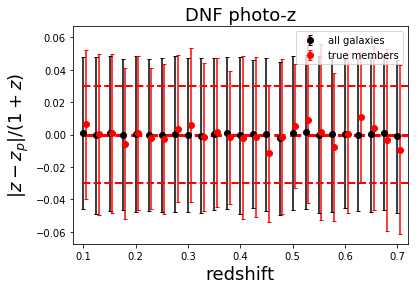

In [262]:
plt.errorbar(zb,bias_b,color='k',fmt='o',capsize=2,yerr=scatter_b,label='all galaxies')
plt.errorbar(zb+0.005,bias_bt,color='r',fmt='o',capsize=2,yerr=scatter_bt,label='true members')

plt.plot([0.1,1.],[0.,0.],'r--',lw=3)
plt.plot([0.1,1.],[-.03,-0.03],'r--',lw=2)
plt.plot([0.1,1.],[+.03,+0.03],'r--',lw=2)

plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.title('DNF photo-z',fontsize=18)
plt.xlim(0.08,0.72)
plt.legend()

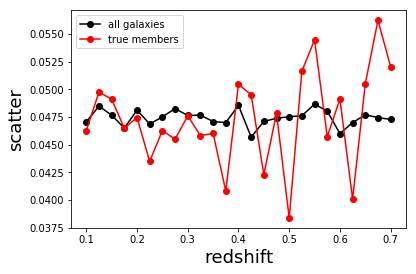

In [263]:
plt.plot(zb,scatter_b,'o-',color='k',label='all galaxies')
plt.plot(zb,scatter_bt,'o-',color='r',label='true members')
plt.ylabel('scatter',fontsize=18)
plt.xlabel('redshift',fontsize=18)
plt.legend()

Text(0.5,0,'redshift')

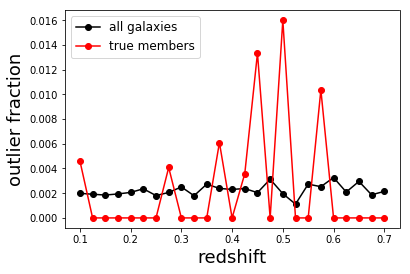

In [264]:
plt.plot(zb,of_b,'o-',color='k',label='all galaxies')
plt.plot(zb,of_bt,'o-',color='r',label='true members')
plt.ylabel('outlier fraction',fontsize=18)
plt.legend(fontsize=12)
plt.xlabel('redshift',fontsize=18)

In [94]:
# outfile  = '../aux_files/zwindow_model_buzzard_dnf.txt'
# savefile = open(outfile, "w")

# with open(outfile, "w") as savefile:
#     header = '#z,bias,sigma,outlier_frac\n'
#     savefile.write(header)
#     for i in range(len(zb)):
#         line = '%.3f,%.3f,%.3f,%.3f\n'%(zb[i],bias_b[i],scatter_b[i],of_b[i])
#         print(line)
#         savefile.write(line)

# savefile.close()

0.100,0.018,0.019,0.062

0.125,0.012,0.022,0.064

0.150,0.002,0.027,0.078

0.175,0.002,0.034,0.083

0.200,0.012,0.033,0.085

0.225,0.017,0.028,0.119

0.250,0.008,0.024,0.148

0.275,-0.001,0.029,0.120

0.300,0.010,0.048,0.010

0.325,0.019,0.035,0.010

0.350,0.013,0.030,0.014

0.375,0.007,0.024,0.012

0.400,0.000,0.020,0.016

0.425,-0.009,0.020,0.011

0.450,-0.016,0.027,0.008

0.475,-0.018,0.034,0.004

0.500,-0.017,0.040,0.003

0.525,-0.018,0.044,0.002

0.550,-0.010,0.036,0.002

0.575,-0.006,0.034,0.005

0.600,-0.001,0.031,0.006

0.625,0.001,0.028,0.012

0.650,0.001,0.026,0.009

0.675,-0.002,0.025,0.010

0.700,-0.004,0.023,0.009



In [265]:
mbins = np.linspace(17,23.,21.)
keys,mb  = get_bins(magi,mbins)
dz_bins_g= group_by(dz,keys)
zerr_bins= group_by(zerr,keys)

scatter_b= np.array([get_sigmaNMAD(db) for db in dz_bins_g])
bias_b   = np.array([np.nanmedian(db) for db in dz_bins_g])
zerr_b   = np.array([np.nanmedian(zb) for zb in zerr_bins]) 

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0.5,0,'mag_i')

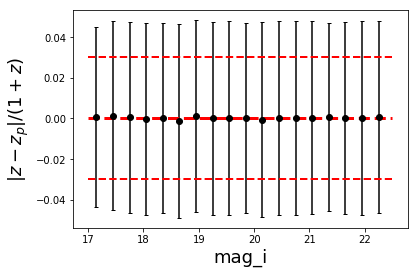

In [266]:
plt.errorbar(mb,bias_b,color='k',fmt='o',capsize=2,yerr=scatter_b)
plt.plot([17.,22.5],[0.,0.],'r--',lw=3)
plt.plot([17.,22.5],[-.03,-0.03],'r--',lw=2)
plt.plot([17.,22.5],[+.03,+0.03],'r--',lw=2)
plt.ylabel(r'$|z-z_p|/(1+z)$',fontsize=18)
plt.xlabel('mag_i',fontsize=18)

Text(0.5,0,'mag_i')

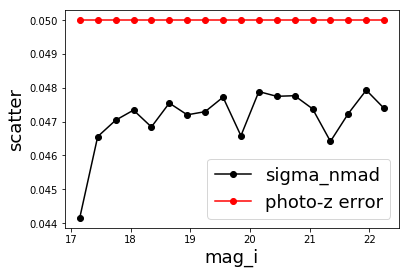

In [267]:
plt.plot(mb,scatter_b,'o-',color='k',label='sigma_nmad')
plt.plot(mb,zerr_b,'o-',color='r',label='photo-z error')
plt.ylabel('scatter',fontsize=18)
plt.legend(fontsize=18)
plt.xlabel('mag_i',fontsize=18)

In [192]:
1.*np.count_nonzero(np.isnan(pz0))/pz0.size

0.0

In [268]:
def plot_pannel(x,y,z,indices,labels,nx=2,ny=4,xlims=(-0.3,0.3),ylims=(-0.3,0.3),ylb=r'$p_{z,0}$',xlb='z'):
    fig = plt.figure(figsize=(5*ny,4*nx))
    fig.subplots_adjust(hspace=0.15, wspace=0.15)
    nplots = int(nx*ny)
    
    cmin,cmax = np.nanpercentile(z,10), np.nanpercentile(z,90)
    for i in range(nplots):
        idx= indices[i]
        ax = plt.subplot(nx, ny, i+1)
        im = ax.scatter(x[idx], y[idx],c=z[idx],label=labels[i],s=10,alpha=0.5,vmin=cmin,vmax=cmax)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.legend()
        
        xc = x[idx]
        #ax.axvline(np.median(xc[y[idx]>0.]),ls='--',lw=2,color='k')
        ax.axvline(0,ls='--',lw=2,color='k')
        if (i+1)%ny == 0:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04,label='$z_{err}$')
        
        if i>=(nx-1)*ny:
            ax.set_xlabel(xlb,fontsize=18)
        
        if ((i)%ny)!=0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(ylb,fontsize=18)
        

In [269]:
def makeBins(variable,xedges):
    xbins = (xedges[1:]+xedges[:-1])/2
    indices = [ np.where((variable >= xedges[i]) & (variable <= xedges[i + 1]))[0] for i in range(len(xedges)-1)]
    return indices, xbins


In [270]:
# dt     = 0.015
# zbins  = np.arange(0.1,1.+dt,dt)
# cut    = np.array([i+3 for i in range(len(zbins[:-3]))])

# keys,zb= makeBins(zcls,zbins[::4])

# zbase  = '%.2f < z < %.2f' 
# labels = [zbase%(zm-dt/2,zm+dt/2) for zm in zb]

In [271]:
zcls = gal['redshift']
zoff = gal['zoffset']
pz0  = gal['pz0']

In [272]:
dt     = 0.025
zbins  = np.arange(0.2,0.7+dt,dt)
cut    = np.array([i+3 for i in range(len(zbins))])

keys,zb= makeBins(zcls,zbins)

zbase  = '%.2f < z < %.2f' 
labels = [zbase%(zm-dt/2,zm+dt/2) for zm in zb]

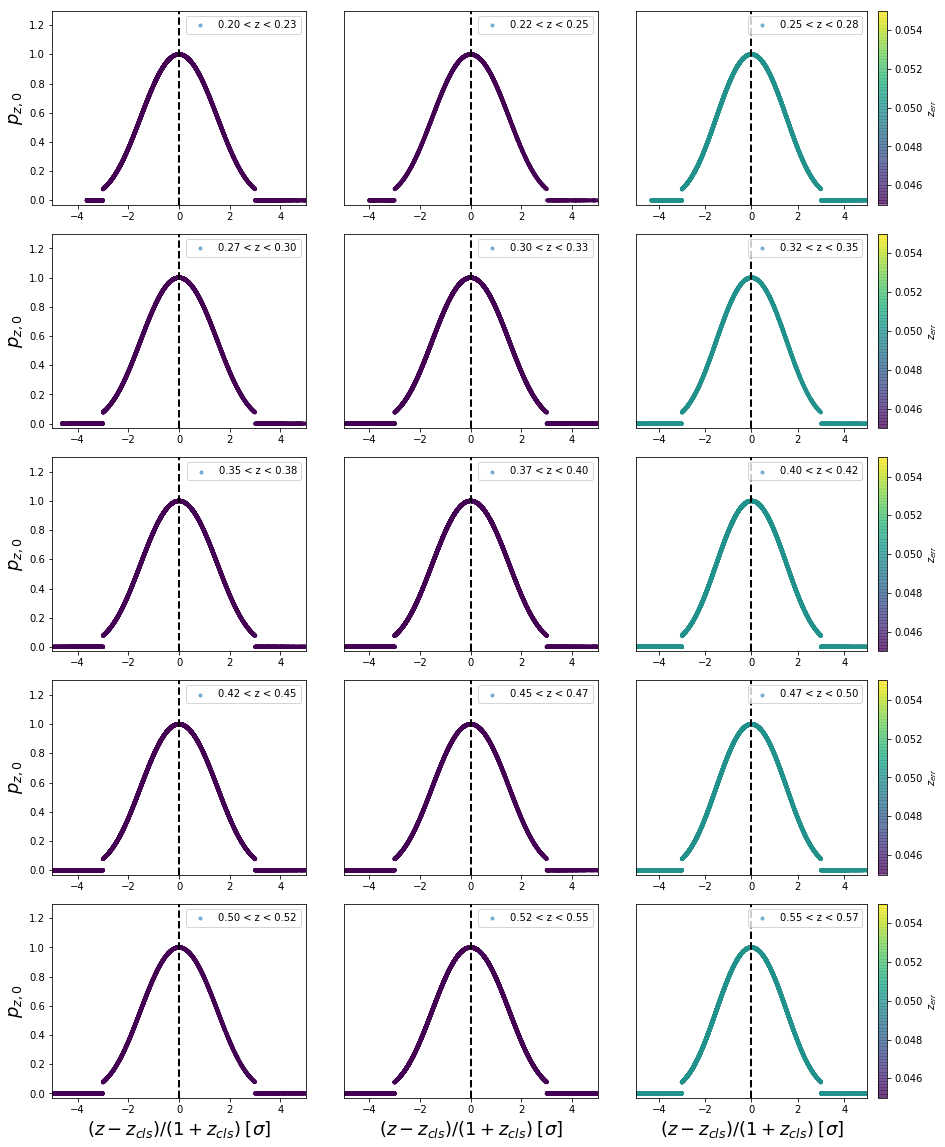

In [273]:
lb=r'$(z-z_{cls})/(1+z_{cls}) \; [\sigma] $'
plot_pannel(zoff/0.05,pz0,zerr,keys,labels,ylims=(-0.03,1.3),xlims=(-5,5),nx=5,ny=3,xlb=lb)

In [115]:
def compute_outlier_fraction(pz,th=0.01):
    return 1.*np.count_nonzero(pz<th)/(len(pz)+1e-6)

In [116]:
dz     = 0.025
zbins  = np.arange(0.1-dz/2,0.9+dz/2,dz)
keys,zb= makeBins(zt,zbins)

ofrac = np.array([compute_outlier_fraction(pz0[idx]) for idx in keys])

Text(0.5,1,'CosmoDC2 - emuBPZ')

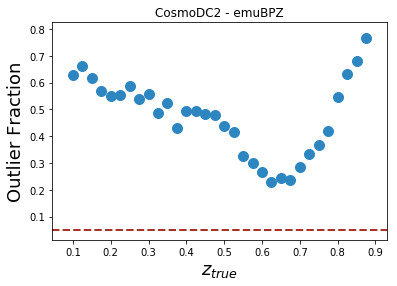

In [117]:
plt.scatter(zb,ofrac,s=100,color=blue)
plt.axhline(0.05,ls='--',lw=2,color=red)
plt.xlabel(r'$z_{true}$',fontsize=18)
plt.ylabel(r'Outlier Fraction',fontsize=18)
plt.title('CosmoDC2 - emuBPZ')

In [118]:
def remove_outliers(x):
    q25,q75 = np.nanpercentile(x,[25,75])
    iqr     = q75-q25
    lo, up  = q25-1.5*iqr, q75+1.5*iqr
    
#     print('lower limit: %.3f'%(lo))
#     print('upper limit: %.3f'%(up))
    
    mask    = (x<up)&(x>lo)
    return mask

In [119]:
# importing library
from scipy.stats import skewnorm 
import scipy.stats as stats

In [120]:
def fit_gauss(z):
    mask = remove_outliers(z)
    zfit = z[mask]
    res  = np.array([np.nanmean(zfit),np.nanstd(zfit),1-1.*np.count_nonzero(mask)/len(z)])
    return res

In [121]:
keys

[array([    18,     29,     30, ..., 254762, 254902, 255625]),
 array([   190,    312,    365, ..., 256523, 256566, 256583]),
 array([     0,      1,      2, ..., 256508, 256530, 256600]),
 array([     6,     45,     48, ..., 256453, 256512, 256618]),
 array([     4,     10,     24, ..., 256539, 256620, 256642]),
 array([    23,     27,    135, ..., 256448, 256479, 256554]),
 array([    88,    103,    185, ..., 256295, 256364, 256559]),
 array([   147,    151,    224, ..., 256607, 256624, 256633]),
 array([   429,    536,    569, ..., 256520, 256573, 256592]),
 array([    32,    263,    282, ..., 256476, 256594, 256628]),
 array([    35,     43,     49, ..., 256401, 256461, 256555]),
 array([   374,    923,   1452, ..., 256601, 256634, 256647]),
 array([    46,    143,    281, ..., 256410, 256568, 256588]),
 array([    13,    832,   1478, ..., 256579, 256597, 256649]),
 array([  2974,   5508,   5530, ..., 256561, 256630, 256631]),
 array([  2225,   4241,   4321, ..., 256586, 256593, 25

In [127]:
zoff = g['zoffset'][g['True']]
zt   = g['z_true'][g['True']]

dx     = 0.025
zbins  = np.arange(0.1-dx/2,0.7+dx/2,dx)
keys,zb= makeBins(zt,zbins)

res  = np.array([fit_gauss(zoff[idx]) for i,idx in enumerate(keys)])
bias = res[:,0]
sigma= res[:,1]
of   = res[:,2]

In [129]:
def fit_skew(zfit,zcut=0.2):
    mask = remove_outliers(zfit)
    zfit = zfit[mask]
    res = skewnorm.fit(zfit)
    return np.array(res)

# res  = np.array([fit_skew(dz[idx],zcut=0.15) for i,idx in enumerate(keys)])
# alpha  = res[:,0]
# bias1  = res[:,1]
# sigma1 = res[:,2]

In [130]:
w, = np.where(np.abs(alpha))

NameError: name 'alpha' is not defined

NameError: name 'zofft' is not defined

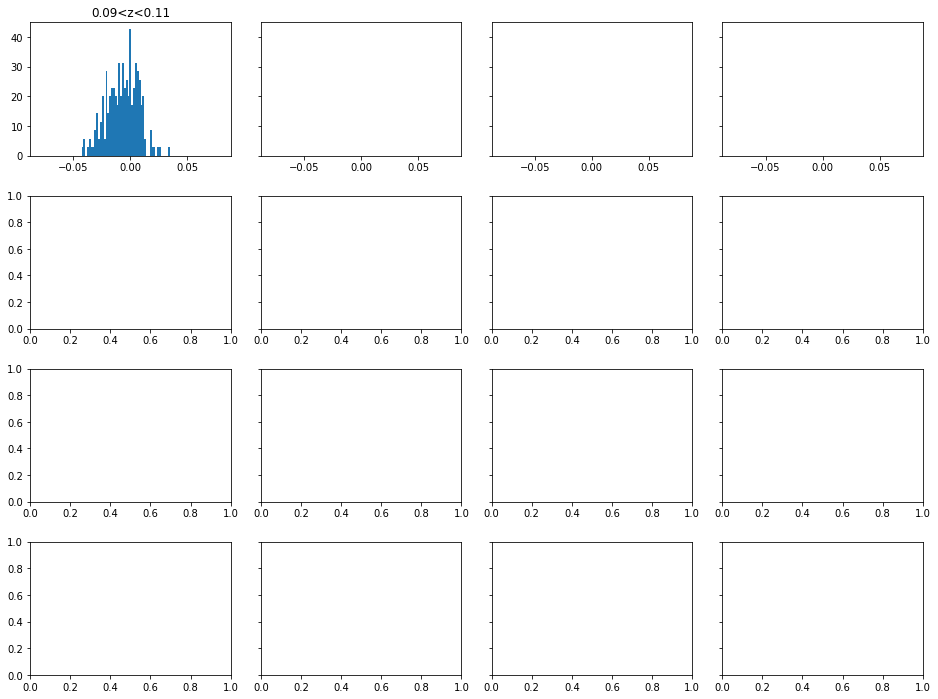

In [131]:
fig, axs = plt.subplots(4, 4, sharey='row', sharex='row', figsize=(16,12))
fig.subplots_adjust(hspace=0.3,wspace=0.15)

axs = axs.flatten()

mybins=np.linspace(-0.08,.08,100)
for i in range(16):
    ii=int(6*i)
    if ii>=len(keys):
        ii = len(keys)-1
    ix = keys[ii]
    ax = axs[i]
    _ = ax.hist(zoff[ix],bins=mybins,density=True,label='true data')
    ax.set_title('%.2f<z<%.2f'%(zbins[ii],zbins[ii+1]))
#     ax.set_yscale('log')
    if i>11:
        ax.set_xlabel(lb,fontsize=14)
    
    zfit = zofft[ix][np.abs(zoff[ix])<0.22]
    ae, loce, scalee = alpha[ii],bias1[ii],sigma1[ii]
    pn = stats.norm.pdf(mybins,loc=bias[ii],scale=sigma[ii])
    p = skewnorm.pdf(mybins, ae,loc=loce,scale=scalee)
    #p = skew_norm_pdf(mybins,0,std,0.)
    ax.plot(mybins,p,label='fitted')
    ax.plot(mybins,pn,label='Normal')
    ax.legend()
    

NameError: name 'sigma1' is not defined

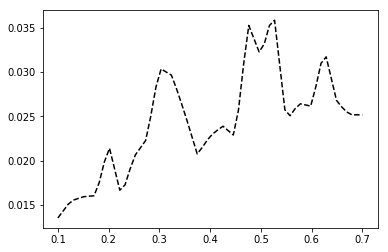

In [132]:
zv = np.linspace(0.1,.7,60)
plt.plot(zv,np.interp(zv,zb,sigma),'k--')
plt.scatter(zb,sigma1*(1+zb))
plt.ylim(0.,0.08)

(-1.0, 6)

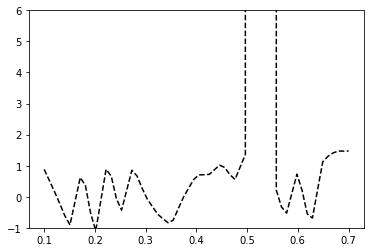

In [178]:
zv = np.linspace(0.1,.7,60)
plt.plot(zv,np.interp(zv,zb,alpha),'k--')
# plt.scatter(zb,sigma1*(1+zb))
plt.ylim(-1.,6)

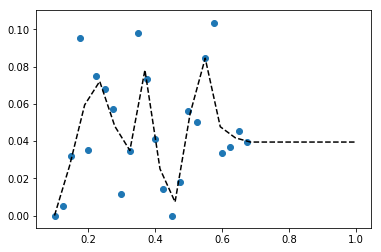

In [173]:
zv = np.linspace(0.1,1.,21)
plt.plot(zv,np.interp(zv,zb,of),'k--')
plt.scatter(zb,of)

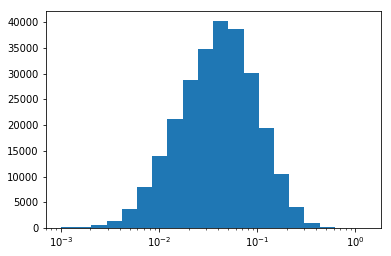

In [163]:
_ = plt.hist(zerr,bins=np.logspace(-3,0.1,21))
plt.xscale('log')

In [94]:
outfile  = 'zwindow_model_emuBPZ.txt'
savefile = open(outfile, "w")

with open(outfile, "w") as savefile:
    header = '#z,bias,sigma,outlier_frac\n'
    savefile.write(header)
    for i in range(len(zb)):
        line = '%.3f,%.3f,%.3f,%.3f\n'%(zb[i],bias[i],sigma[i],of[i])
        savefile.write(line)

savefile.close()